In [1]:
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk import trigrams
from nltk import bigrams
from collections import Counter

import pandas as pd
import numpy as np
import os
import time
import csv
import json
from typing import Dict, List, Optional, Union, cast
import requests
import prepare

import seaborn as sns
import matplotlib as plt

from bs4 import BeautifulSoup

df = prepare.wrangle_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257 entries, 0 to 390
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             257 non-null    object
 1   language         257 non-null    object
 2   readme_contents  257 non-null    object
 3   stemmed          257 non-null    object
 4   lemmatized       257 non-null    object
dtypes: object(5)
memory usage: 12.0+ KB


#### prepare notes-
- talk about handling nulls, decision to drop langs with < 5 records, and JN
- talk about steps to get lemmatized column

In [2]:
df.head()

,repo,language,readme_contents,stemmed,lemmatized
0,dreamingechoes/awesome-mental-health,HTML,"\n<p align=""center""><img src=""./media/logo.png...",aboutsparkl curat list awesom articl websit re...,aboutsparkles curated list awesome article web...
1,Flaque/quirk,TypeScript,🚧🚧🚧\n\n**Quirk is no longer being maintained.*...,quirk longer maintainedquirk start littl thing...,quirk longer maintainedquirk started little th...
4,sepandhaghighi/nafas,Python,"<div align=""center"">\n<img src=""https://github...",nafa &#9; tabl content overview instal usag is...,nafas &#9; table content overview installation...
5,youarerad/youareradweb,TypeScript,"<div align=""center""><img src=""https://res.clou...",welcom rise disord ' websit repow nonprofit co...,welcome rise disorder ' website repowe nonprof...
7,OSMIHelp/osmi-survey-graph,PHP,# 2016 OSMI Survey Graph\n\n## Installing and ...,2016 osmi survey graph instal run copi envexam...,2016 osmi survey graph installing running copy...


In [3]:
df.language.nunique()

12

In [4]:
df.language.value_counts()

JavaScript    62
HTML          44
Python        41
TypeScript    24
Java          22
Dart          14
R             13
CSS           12
Swift          9
Vue            6
PHP            5
C++            5
Name: language, dtype: int64

#### show counts and percentage of languages

- put this in function

In [5]:
langs = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
langs.columns = ['counts', 'percent']
langs

,counts,percent
JavaScript,62,0.241245
HTML,44,0.171206
Python,41,0.159533
TypeScript,24,0.093385
Java,22,0.085603
Dart,14,0.054475
R,13,0.050584
CSS,12,0.046693
Swift,9,0.035019
Vue,6,0.023346


In [6]:
ADDITIONAL = ['The', 'I', 'This','Mental','Health','mental','health']
def clean(readme_contents):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL
    text = (unicodedata.normalize('NFKD', readme_contents)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
#     words = re.sub(r"[^a-z0-9'\s]", '', readme_contents).split()
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [7]:
JavaScript_words = clean(' '.join(df[df.language == 'JavaScript'].readme_contents))
HTML_words = clean(' '.join(df[df.language == 'HTML'].readme_contents))
Python_words = clean(' '.join(df[df.language == 'Python'].readme_contents))
TypeScript_words = clean(' '.join(df[df.language == 'TypeScript'].readme_contents))
Java_words = clean(' '.join(df[df.language == 'Java'].readme_contents))
Dart_words = clean(' '.join(df[df.language == 'Dart'].readme_contents))
CSS_words = clean(' '.join(df[df.language == 'CSS'].readme_contents))
R_words = clean(' '.join(df[df.language == 'R'].readme_contents))
Swift_words = clean(' '.join(df[df.language == 'Swift'].readme_contents))
Vue_words = clean(' '.join(df[df.language == 'Vue'].readme_contents))
PHP_words = clean(' '.join(df[df.language == 'PHP'].readme_contents))
C_words = clean(' '.join(df[df.language == 'C++'].readme_contents))
all_words = clean(' '.join(df.readme_contents))

In [8]:
df['total_words'] = df['lemmatized'].str.split().str.len()

In [9]:
df = df[df.total_words > 5]

In [10]:
df

,repo,language,readme_contents,stemmed,lemmatized,total_words
0,dreamingechoes/awesome-mental-health,HTML,"\n<p align=""center""><img src=""./media/logo.png...",aboutsparkl curat list awesom articl websit re...,aboutsparkles curated list awesome article web...,1140
1,Flaque/quirk,TypeScript,🚧🚧🚧\n\n**Quirk is no longer being maintained.*...,quirk longer maintainedquirk start littl thing...,quirk longer maintainedquirk started little th...,1061
4,sepandhaghighi/nafas,Python,"<div align=""center"">\n<img src=""https://github...",nafa &#9; tabl content overview instal usag is...,nafas &#9; table content overview installation...,351
5,youarerad/youareradweb,TypeScript,"<div align=""center""><img src=""https://res.clou...",welcom rise disord ' websit repow nonprofit co...,welcome rise disorder ' website repowe nonprof...,83
7,OSMIHelp/osmi-survey-graph,PHP,# 2016 OSMI Survey Graph\n\n## Installing and ...,2016 osmi survey graph instal run copi envexam...,2016 osmi survey graph installing running copy...,419
...,...,...,...,...,...,...
380,EdwardRees/Self-Care-Project,TypeScript,# Self Care Project\n\nWhat used to be a Menta...,self care projectwhat use mental health projec...,self care projectwhat used mental health proje...,49
384,sumantchirde/Mental-Health-NLP-project,Python,# Mental health assessment by NLP and ML usin...,mental health assess nlp ml use tensorflownowa...,mental health assessment nlp ml using tensorfl...,88
385,Levodex/RipplerPy,JavaScript,## About\n* \n* (Read github/bitbucket descrip...,read githubbitbucket descript copyright notice...,read githubbitbucket description copyright not...,155
387,acfromspace/soulstone,HTML,"<!-- HEADING -->\n\n<h1 align=""center"">soulsto...",soulstoneperson reflect thought one ' selfswee...,soulstonepersonal reflection thought one ' sel...,15


<AxesSubplot:>

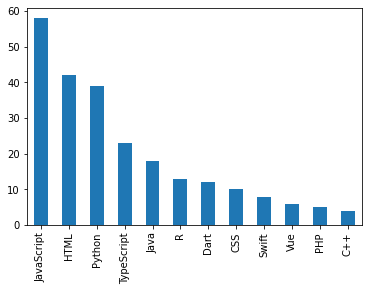

In [11]:
df.language.value_counts().plot(kind='bar')

<AxesSubplot:xlabel='language'>

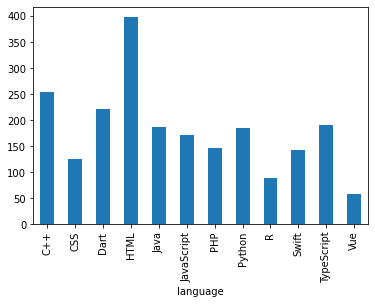

In [12]:
df.total_words.groupby(df.language).mean().plot(kind='bar')

In [13]:
conditions = [(df.total_words > 183),
              (df.total_words >= 66) & (df.total_words <= 183),
              (df.total_words < 66)]
choices = ['high_count', 'med_count', 'low_count']

df['count_bin'] = np.select(conditions, choices)

In [14]:
df_plot = df.groupby(['language', 'count_bin']).size().reset_index().pivot(columns='count_bin', index='language', values=0)

<AxesSubplot:xlabel='language'>

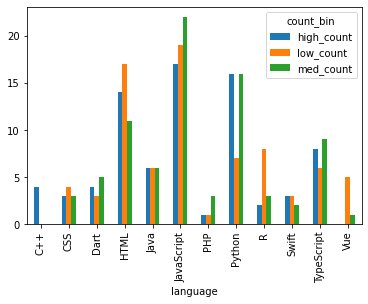

In [15]:
df_plot.plot(kind='bar')

In [16]:
df

,repo,language,readme_contents,stemmed,lemmatized,total_words,count_bin
0,dreamingechoes/awesome-mental-health,HTML,"\n<p align=""center""><img src=""./media/logo.png...",aboutsparkl curat list awesom articl websit re...,aboutsparkles curated list awesome article web...,1140,high_count
1,Flaque/quirk,TypeScript,🚧🚧🚧\n\n**Quirk is no longer being maintained.*...,quirk longer maintainedquirk start littl thing...,quirk longer maintainedquirk started little th...,1061,high_count
4,sepandhaghighi/nafas,Python,"<div align=""center"">\n<img src=""https://github...",nafa &#9; tabl content overview instal usag is...,nafas &#9; table content overview installation...,351,high_count
5,youarerad/youareradweb,TypeScript,"<div align=""center""><img src=""https://res.clou...",welcom rise disord ' websit repow nonprofit co...,welcome rise disorder ' website repowe nonprof...,83,med_count
7,OSMIHelp/osmi-survey-graph,PHP,# 2016 OSMI Survey Graph\n\n## Installing and ...,2016 osmi survey graph instal run copi envexam...,2016 osmi survey graph installing running copy...,419,high_count
...,...,...,...,...,...,...,...
380,EdwardRees/Self-Care-Project,TypeScript,# Self Care Project\n\nWhat used to be a Menta...,self care projectwhat use mental health projec...,self care projectwhat used mental health proje...,49,low_count
384,sumantchirde/Mental-Health-NLP-project,Python,# Mental health assessment by NLP and ML usin...,mental health assess nlp ml use tensorflownowa...,mental health assessment nlp ml using tensorfl...,88,med_count
385,Levodex/RipplerPy,JavaScript,## About\n* \n* (Read github/bitbucket descrip...,read githubbitbucket descript copyright notice...,read githubbitbucket description copyright not...,155,med_count
387,acfromspace/soulstone,HTML,"<!-- HEADING -->\n\n<h1 align=""center"">soulsto...",soulstoneperson reflect thought one ' selfswee...,soulstonepersonal reflection thought one ' sel...,15,low_count


In [17]:
JavaScript_freq = pd.Series(JavaScript_words).value_counts()
HTML_freq = pd.Series(HTML_words).value_counts()
Python_freq = pd.Series(Python_words).value_counts()
TypeScript_freq = pd.Series(TypeScript_words).value_counts()
Java_freq = pd.Series(Java_words).value_counts()
Dart_freq = pd.Series(Dart_words).value_counts()
CSS_freq = pd.Series(CSS_words).value_counts()
R_freq = pd.Series(R_words).value_counts()
Swift_freq = pd.Series(Swift_words).value_counts()
Vue_freq = pd.Series(Vue_words).value_counts()
PHP_freq = pd.Series(PHP_words).value_counts()
C_freq = pd.Series(C_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [18]:
word_counts = (pd.concat([all_freq, JavaScript_freq, HTML_freq, Python_freq, TypeScript_freq,
                    Java_freq, Dart_freq, CSS_freq, R_freq, Swift_freq, Vue_freq, PHP_freq, C_freq], axis=1, sort=True)
                .set_axis(['all', 'JavaScript', 'HTML', 'Python', 'TypeScript', 'Java', 'Dart', 'CSS', 'R', 'Swift', 'Vue', 'PHP', 'C++'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,JavaScript,HTML,Python,TypeScript,Java,Dart,CSS,R,Swift,Vue,PHP,C++
0,35,10,16,0,8,0,0,0,0,0,0,1,0
000,2,0,1,0,0,0,1,0,0,0,0,0,0
0000,1,0,1,0,0,0,0,0,0,0,0,0,0
00000,2,0,2,0,0,0,0,0,0,0,0,0,0
0001,10,0,9,1,0,0,0,0,0,0,0,0,0


In [19]:
word_counts.sort_values(by='all', ascending=False).head(20)

,all,JavaScript,HTML,Python,TypeScript,Java,Dart,CSS,R,Swift,Vue,PHP,C++
user,478,98,197,34,26,67,26,2,0,18,3,4,3
project,348,70,89,34,42,35,33,20,9,3,3,4,6
page,315,69,193,2,19,10,3,8,0,3,3,2,3
app,293,83,26,8,57,34,46,4,1,28,4,1,1
help,264,38,98,30,36,8,28,8,2,9,2,0,5
data,254,39,46,79,16,22,14,0,20,5,2,5,6
img,245,36,51,35,17,32,37,20,1,9,5,0,2
br,236,48,122,11,10,13,10,2,0,0,11,6,3
1,228,41,112,19,17,10,12,6,1,4,3,0,3
use,219,58,60,30,17,13,8,10,1,3,1,4,14


In [20]:
word_counts.sort_values(by='all', ascending=False).head(20)

,all,JavaScript,HTML,Python,TypeScript,Java,Dart,CSS,R,Swift,Vue,PHP,C++
user,478,98,197,34,26,67,26,2,0,18,3,4,3
project,348,70,89,34,42,35,33,20,9,3,3,4,6
page,315,69,193,2,19,10,3,8,0,3,3,2,3
app,293,83,26,8,57,34,46,4,1,28,4,1,1
help,264,38,98,30,36,8,28,8,2,9,2,0,5
data,254,39,46,79,16,22,14,0,20,5,2,5,6
img,245,36,51,35,17,32,37,20,1,9,5,0,2
br,236,48,122,11,10,13,10,2,0,0,11,6,3
1,228,41,112,19,17,10,12,6,1,4,3,0,3
use,219,58,60,30,17,13,8,10,1,3,1,4,14


In [21]:
most_freq_155 = word_counts[word_counts['all'] > 155] 
most_freq_155 = most_freq_155[most_freq_155['all'] < 180]
most_freq_180 = word_counts[word_counts['all'] >= 180]
most_freq_180 = most_freq_180[most_freq_180['all'] < 220]
most_freq = word_counts[word_counts['all'] >= 220]

In [22]:
most_freq.head()

,all,JavaScript,HTML,Python,TypeScript,Java,Dart,CSS,R,Swift,Vue,PHP,C++
1,228,41,112,19,17,10,12,6,1,4,3,0,3
app,293,83,26,8,57,34,46,4,1,28,4,1,1
br,236,48,122,11,10,13,10,2,0,0,11,6,3
data,254,39,46,79,16,22,14,0,20,5,2,5,6
help,264,38,98,30,36,8,28,8,2,9,2,0,5


In [23]:
word_perc = pd.DataFrame()
for col in most_freq.columns:
    word_perc = word_perc.append(most_freq[col].sort_values(ascending=False)/most_freq[col].sum())

word_perc_155 = pd.DataFrame()
for col in most_freq_155.columns:
    word_perc_155 = word_perc_155.append(most_freq_155[col].sort_values(ascending=False)/most_freq_155[col].sum())
    
word_perc_180 = pd.DataFrame()
for col in most_freq_180.columns:
    word_perc_180 = word_perc_180.append(most_freq_180[col].sort_values(ascending=False)/most_freq_180[col].sum())

In [24]:
word_perc

,user,project,page,app,help,data,img,br,1
all,0.179632,0.130778,0.118377,0.110109,0.099211,0.095453,0.092071,0.088688,0.085682
JavaScript,0.187739,0.134100,0.132184,0.159004,0.072797,0.074713,0.068966,0.091954,0.078544
HTML,0.210921,0.095289,0.206638,0.027837,0.104925,0.049251,0.054604,0.130621,0.119914
Python,0.134921,0.134921,0.007937,0.031746,0.119048,0.313492,0.138889,0.043651,0.075397
TypeScript,0.108333,0.175000,0.079167,0.237500,0.150000,0.066667,0.070833,0.041667,0.070833
Java,0.290043,0.151515,0.043290,0.147186,0.034632,0.095238,0.138528,0.056277,0.043290
Dart,0.124402,0.157895,0.014354,0.220096,0.133971,0.066986,0.177033,0.047847,0.057416
CSS,0.028571,0.285714,0.114286,0.057143,0.114286,0.000000,0.285714,0.028571,0.085714
R,0.000000,0.264706,0.000000,0.029412,0.058824,0.588235,0.029412,0.000000,0.029412
Swift,0.227848,0.037975,0.037975,0.354430,0.113924,0.063291,0.113924,0.000000,0.050633


<AxesSubplot:>

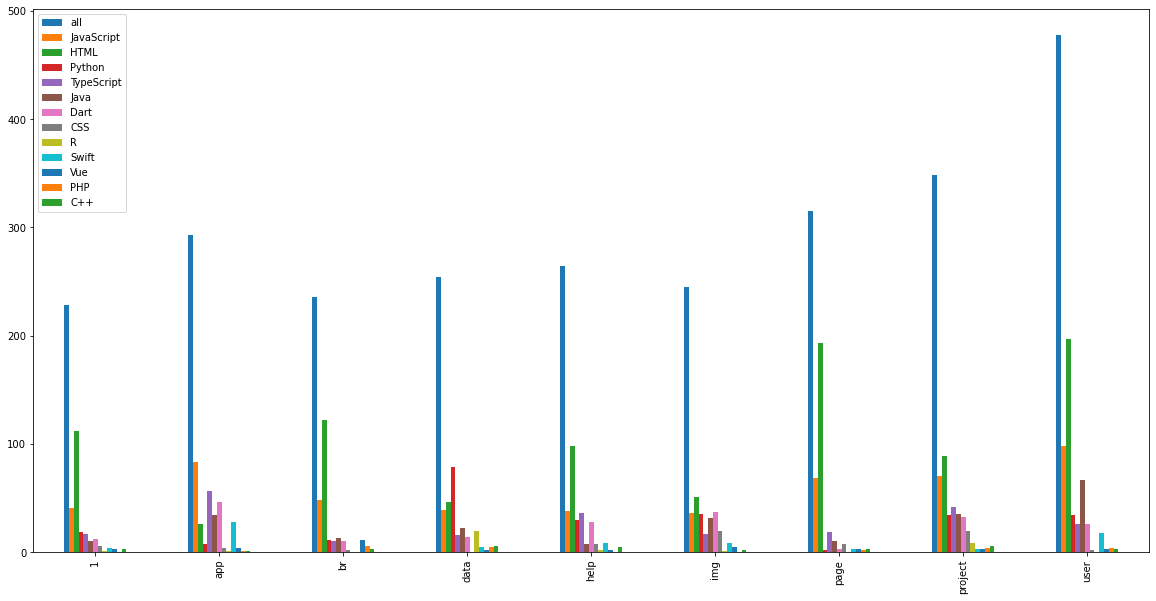

In [25]:
plt.rcParams["figure.figsize"] = (20,10)
most_freq.plot(kind='bar')

<AxesSubplot:>

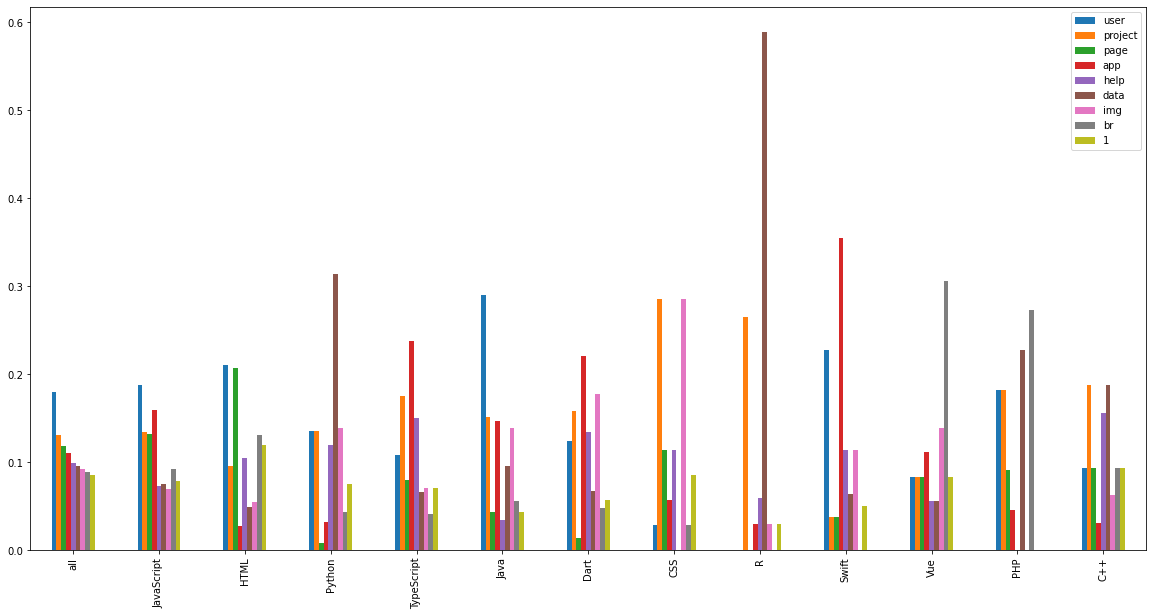

In [26]:
plt.rcParams["figure.figsize"] = (20,10)
word_perc.plot(kind='bar')

In [27]:
word_perc_T = word_perc.T
word_perc_155_T = word_perc_155.T
word_perc_180_T = word_perc_180.T

to look at similarities, we simple look at bars w similar heights. That will show they have a similar distribution of that specific word

<AxesSubplot:>

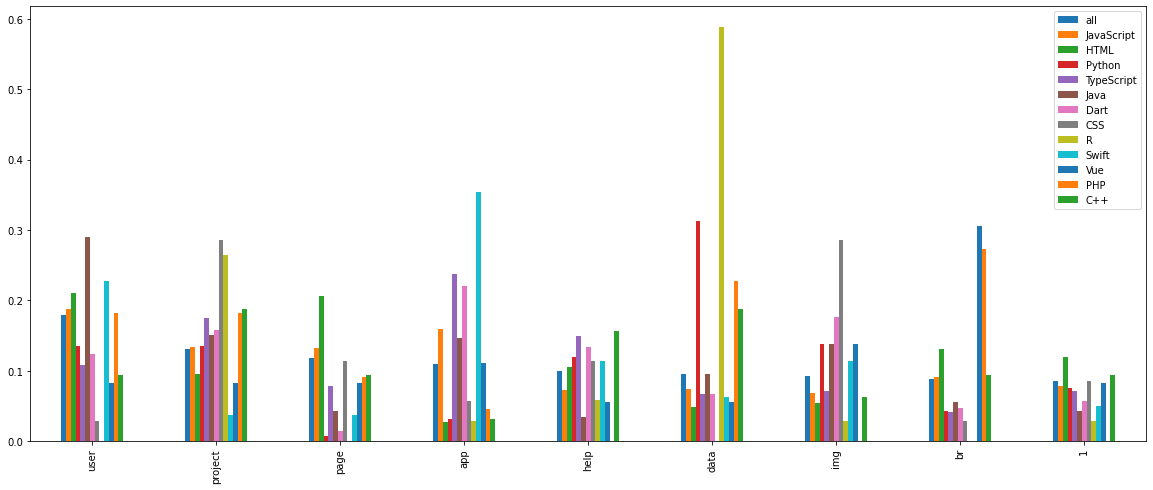

In [28]:
plt.rcParams["figure.figsize"] = (20,8)
word_perc_T.plot(kind='bar')

<AxesSubplot:>

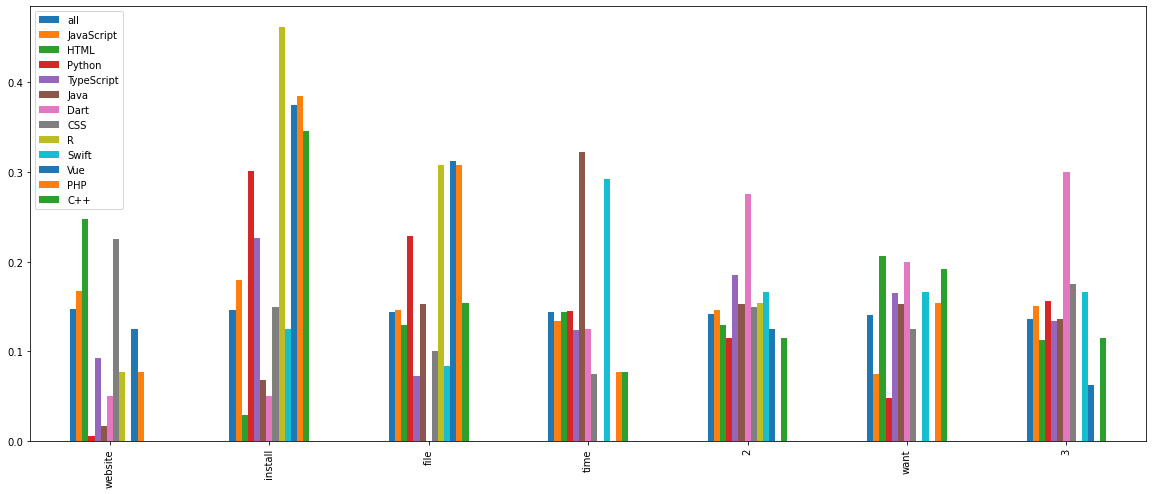

In [29]:
plt.rcParams["figure.figsize"] = (20,8)
word_perc_155_T.plot(kind='bar')

In [30]:
word_perc_T

,all,JavaScript,HTML,Python,TypeScript,Java,Dart,CSS,R,Swift,Vue,PHP,C++
user,0.179632,0.187739,0.210921,0.134921,0.108333,0.290043,0.124402,0.028571,0.000000,0.227848,0.083333,0.181818,0.09375
project,0.130778,0.134100,0.095289,0.134921,0.175000,0.151515,0.157895,0.285714,0.264706,0.037975,0.083333,0.181818,0.18750
page,0.118377,0.132184,0.206638,0.007937,0.079167,0.043290,0.014354,0.114286,0.000000,0.037975,0.083333,0.090909,0.09375
app,0.110109,0.159004,0.027837,0.031746,0.237500,0.147186,0.220096,0.057143,0.029412,0.354430,0.111111,0.045455,0.03125
help,0.099211,0.072797,0.104925,0.119048,0.150000,0.034632,0.133971,0.114286,0.058824,0.113924,0.055556,0.000000,0.15625
data,0.095453,0.074713,0.049251,0.313492,0.066667,0.095238,0.066986,0.000000,0.588235,0.063291,0.055556,0.227273,0.18750
img,0.092071,0.068966,0.054604,0.138889,0.070833,0.138528,0.177033,0.285714,0.029412,0.113924,0.138889,0.000000,0.06250
br,0.088688,0.091954,0.130621,0.043651,0.041667,0.056277,0.047847,0.028571,0.000000,0.000000,0.305556,0.272727,0.09375
1,0.085682,0.078544,0.119914,0.075397,0.070833,0.043290,0.057416,0.085714,0.029412,0.050633,0.083333,0.000000,0.09375


<AxesSubplot:>

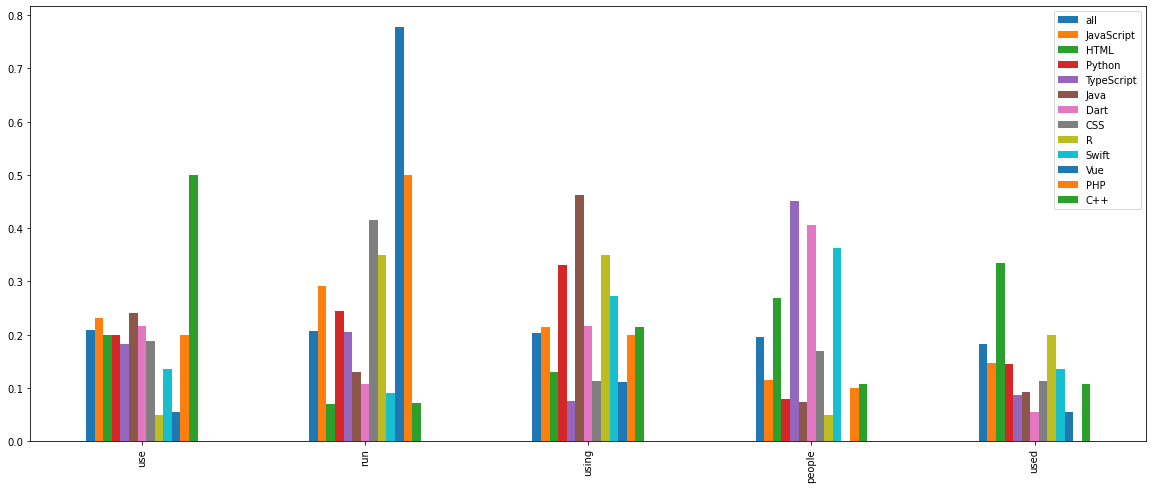

In [31]:
plt.rcParams["figure.figsize"] = (20,8)
word_perc_180_T.plot(kind='bar')

In [32]:
langs = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
langs.columns = ['counts', 'percent']
langs

,counts,percent
JavaScript,58,0.243697
HTML,42,0.176471
Python,39,0.163866
TypeScript,23,0.096639
Java,18,0.075630
R,13,0.054622
Dart,12,0.050420
CSS,10,0.042017
Swift,8,0.033613
Vue,6,0.025210


In [33]:
df

,repo,language,readme_contents,stemmed,lemmatized,total_words,count_bin
0,dreamingechoes/awesome-mental-health,HTML,"\n<p align=""center""><img src=""./media/logo.png...",aboutsparkl curat list awesom articl websit re...,aboutsparkles curated list awesome article web...,1140,high_count
1,Flaque/quirk,TypeScript,🚧🚧🚧\n\n**Quirk is no longer being maintained.*...,quirk longer maintainedquirk start littl thing...,quirk longer maintainedquirk started little th...,1061,high_count
4,sepandhaghighi/nafas,Python,"<div align=""center"">\n<img src=""https://github...",nafa &#9; tabl content overview instal usag is...,nafas &#9; table content overview installation...,351,high_count
5,youarerad/youareradweb,TypeScript,"<div align=""center""><img src=""https://res.clou...",welcom rise disord ' websit repow nonprofit co...,welcome rise disorder ' website repowe nonprof...,83,med_count
7,OSMIHelp/osmi-survey-graph,PHP,# 2016 OSMI Survey Graph\n\n## Installing and ...,2016 osmi survey graph instal run copi envexam...,2016 osmi survey graph installing running copy...,419,high_count
...,...,...,...,...,...,...,...
380,EdwardRees/Self-Care-Project,TypeScript,# Self Care Project\n\nWhat used to be a Menta...,self care projectwhat use mental health projec...,self care projectwhat used mental health proje...,49,low_count
384,sumantchirde/Mental-Health-NLP-project,Python,# Mental health assessment by NLP and ML usin...,mental health assess nlp ml use tensorflownowa...,mental health assessment nlp ml using tensorfl...,88,med_count
385,Levodex/RipplerPy,JavaScript,## About\n* \n* (Read github/bitbucket descrip...,read githubbitbucket descript copyright notice...,read githubbitbucket description copyright not...,155,med_count
387,acfromspace/soulstone,HTML,"<!-- HEADING -->\n\n<h1 align=""center"">soulsto...",soulstoneperson reflect thought one ' selfswee...,soulstonepersonal reflection thought one ' sel...,15,low_count


In [34]:
trigrams = [x for x in df['lemmatized'] for x in trigrams(x.split())]
trigrams

[('aboutsparkles', 'curated', 'list'),
 ('curated', 'list', 'awesome'),
 ('list', 'awesome', 'article'),
 ('awesome', 'article', 'website'),
 ('article', 'website', 'resource'),
 ('website', 'resource', 'mental'),
 ('resource', 'mental', 'health'),
 ('mental', 'health', 'software'),
 ('health', 'software', 'industry'),
 ('software', 'industry', 'sparklesmental'),
 ('industry', 'sparklesmental', 'health'),
 ('sparklesmental', 'health', 'level'),
 ('health', 'level', 'psychological'),
 ('level', 'psychological', 'wellbeing'),
 ('psychological', 'wellbeing', 'absence'),
 ('wellbeing', 'absence', 'mental'),
 ('absence', 'mental', 'illness'),
 ('mental', 'illness', "'"),
 ('illness', "'", 'psychological'),
 ("'", 'psychological', 'state'),
 ('psychological', 'state', 'someone'),
 ('state', 'someone', 'functioning'),
 ('someone', 'functioning', 'satisfactory'),
 ('functioning', 'satisfactory', 'level'),
 ('satisfactory', 'level', 'emotional'),
 ('level', 'emotional', 'behavioural'),
 ('emoti

In [35]:
tri_counts = Counter(trigrams)
print (tri_counts)

Counter({("'", 'section', "'"): 34, ('nbsp', 'nbsp', 'nbsp'): 27, ("'", 'help', "'"): 26, ("'", 'home', "'"): 25, ('mental', 'health', 'issue'): 24, ('section', "'", 'help'): 22, ('mental', 'health', 'tech'): 21, ("'", 'spread', 'word'): 21, ('spread', 'word', "'"): 21, ('home', "'", 'page'): 17, ("'", 'sign', "'"): 17, ("'", 'page', 'user'): 17, ("'", 'mental', 'health'): 16, ('mental', 'health', 'disorder'): 16, ("'", 'help', 'others'): 16, ('help', 'others', "'"): 16, ('front', 'line', 'worker'): 16, ('mental', 'health', 'problem'): 15, ('help', "'", 'page'): 15, ('word', "'", 'page'): 15, ("'", 'educate', "'"): 14, ('mental', 'health', 'awareness'): 13, ("'", 'resource', "'"): 13, ('member', 'github', 'team'): 12, ('github', 'team', 'member'): 12, ('team', 'member', 'social'): 12, ('mental', 'health', 'condition'): 11, ('resource', "'", 'section'): 11, ('showing', 'first', 'part'): 11, ('first', 'part', "'"): 11, ('hide', 'feed', 'home'): 10, ('feed', 'home', 'page'): 10, ('others'

In [36]:
top = tri_counts.most_common(10)
print (top)

[(("'", 'section', "'"), 34), (('nbsp', 'nbsp', 'nbsp'), 27), (("'", 'help', "'"), 26), (("'", 'home', "'"), 25), (('mental', 'health', 'issue'), 24), (('section', "'", 'help'), 22), (('mental', 'health', 'tech'), 21), (("'", 'spread', 'word'), 21), (('spread', 'word', "'"), 21), (('home', "'", 'page'), 17)]


In [37]:
# df['bigrams'] = all_words.apply(lambda row: list(nltk.ngrams(row, 2)))

In [38]:
# from nltk.util import ngrams

# n = 2
# bigrams = all_words.apply(lambda x:" ".join(x for x in x.split(), n))

In [39]:
df

,repo,language,readme_contents,stemmed,lemmatized,total_words,count_bin
0,dreamingechoes/awesome-mental-health,HTML,"\n<p align=""center""><img src=""./media/logo.png...",aboutsparkl curat list awesom articl websit re...,aboutsparkles curated list awesome article web...,1140,high_count
1,Flaque/quirk,TypeScript,🚧🚧🚧\n\n**Quirk is no longer being maintained.*...,quirk longer maintainedquirk start littl thing...,quirk longer maintainedquirk started little th...,1061,high_count
4,sepandhaghighi/nafas,Python,"<div align=""center"">\n<img src=""https://github...",nafa &#9; tabl content overview instal usag is...,nafas &#9; table content overview installation...,351,high_count
5,youarerad/youareradweb,TypeScript,"<div align=""center""><img src=""https://res.clou...",welcom rise disord ' websit repow nonprofit co...,welcome rise disorder ' website repowe nonprof...,83,med_count
7,OSMIHelp/osmi-survey-graph,PHP,# 2016 OSMI Survey Graph\n\n## Installing and ...,2016 osmi survey graph instal run copi envexam...,2016 osmi survey graph installing running copy...,419,high_count
...,...,...,...,...,...,...,...
380,EdwardRees/Self-Care-Project,TypeScript,# Self Care Project\n\nWhat used to be a Menta...,self care projectwhat use mental health projec...,self care projectwhat used mental health proje...,49,low_count
384,sumantchirde/Mental-Health-NLP-project,Python,# Mental health assessment by NLP and ML usin...,mental health assess nlp ml use tensorflownowa...,mental health assessment nlp ml using tensorfl...,88,med_count
385,Levodex/RipplerPy,JavaScript,## About\n* \n* (Read github/bitbucket descrip...,read githubbitbucket descript copyright notice...,read githubbitbucket description copyright not...,155,med_count
387,acfromspace/soulstone,HTML,"<!-- HEADING -->\n\n<h1 align=""center"">soulsto...",soulstoneperson reflect thought one ' selfswee...,soulstonepersonal reflection thought one ' sel...,15,low_count


In [40]:
df = df[df.language!='Vue']
df = df[df.language!='PHP']
df = df[df.language!='C++']
#, 'PHP', 'C++']

In [54]:
df.head()

,repo,language,readme_contents,stemmed,lemmatized,total_words,count_bin
0,dreamingechoes/awesome-mental-health,HTML,"\n<p align=""center""><img src=""./media/logo.png...",aboutsparkl curat list awesom articl websit re...,aboutsparkles curated list awesome article web...,1140,high_count
1,Flaque/quirk,TypeScript,🚧🚧🚧\n\n**Quirk is no longer being maintained.*...,quirk longer maintainedquirk start littl thing...,quirk longer maintainedquirk started little th...,1061,high_count
4,sepandhaghighi/nafas,Python,"<div align=""center"">\n<img src=""https://github...",nafa &#9; tabl content overview instal usag is...,nafas &#9; table content overview installation...,351,high_count
5,youarerad/youareradweb,TypeScript,"<div align=""center""><img src=""https://res.clou...",welcom rise disord ' websit repow nonprofit co...,welcome rise disorder ' website repowe nonprof...,83,med_count
8,chroline/well_app,Dart,![The Well App](thumbnail.png)\n\n<div align='...,well appthumbnailpng quick link well app avail...,well appthumbnailpng quick link well app avail...,320,high_count


In [41]:
top_20_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_bigrams.head(20)

(br, br)               77
(p, aligncenter)       48
(img, src)             48
(home, page)           48
(nbsp, nbsp)           46
(team, member)         44
(git, clone)           35
(image, showing)       33
(npm, run)             32
(social, medium)       31
(td, aligncentera)     30
(aligncenter, img)     28
(open, source)         28
(npm, install)         28
(navigation, bar)      25
(front, line)          25
(page, user)           24
(line, worker)         24
(section, help)        23
(machine, learning)    23
dtype: int64

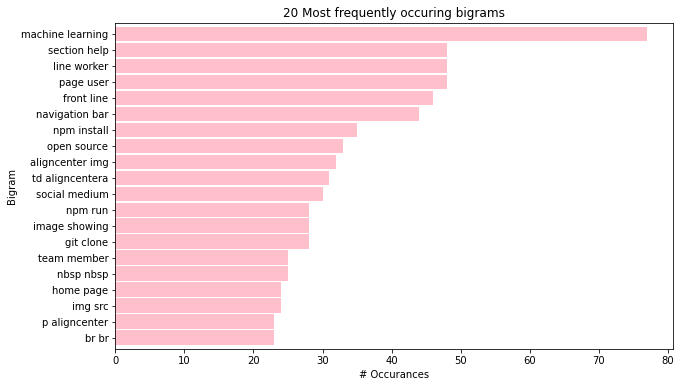

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
top_20_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report


tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.stemmed)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)


In [45]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 73.60%
---
Confusion Matrix
actual      CSS  Dart  HTML  Java  JavaScript  Python  R  Swift  TypeScript
predicted                                                                  
HTML          0     1    33     0           0       0  1      0           0
Java          0     0     0     7           0       0  0      0           0
JavaScript    7     9     1     7          46       0  2      7          10
Python        1     0     0     0           0      31  1      0           0
R             0     0     0     0           0       0  6      0           0
TypeScript    0     0     0     0           0       0  0      0           8
---
              precision    recall  f1-score   support

         CSS       0.00      0.00      0.00         8
        Dart       0.00      0.00      0.00        10
        HTML       0.94      0.97      0.96        34
        Java       1.00      0.50      0.67        14
  JavaScript       0.52      1.00      0.68        46
      Python       0.94  

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 31.11%
---
Confusion Matrix
actual      CSS  Dart  HTML  Java  JavaScript  Python  R  Swift  TypeScript
predicted                                                                  
HTML          0     0     2     0           1       0  1      0           0
JavaScript    1     2     6     4          10       7  2      1           4
Python        1     0     0     0           1       1  0      0           0
TypeScript    0     0     0     0           0       0  0      0           1
---
              precision    recall  f1-score   support

         CSS       0.00      0.00      0.00         2
        Dart       0.00      0.00      0.00         2
        HTML       0.50      0.25      0.33         8
        Java       0.00      0.00      0.00         4
  JavaScript       0.27      0.83      0.41        12
      Python       0.33      0.12      0.18         8
           R       0.00      0.00      0.00         3
       Swift       0.00      0.00      0.00         1
  TypeScript   

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.stemmed)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=15, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_test, y_test) * 100:.2f}%')

Accuracy Score: 35.56%


In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report
from sklearn import tree


In [49]:
cv = CountVectorizer()
X = cv.fit_transform(df.stemmed)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=9, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_test, y_test) * 100:.2f}%')

Accuracy Score: 35.56%


In [50]:
cv = CountVectorizer(ngram_range=(2, 2))
X = cv.fit_transform(df.stemmed)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=7, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_train, y_train) * 100:.2f}%')

Accuracy Score: 45.86%


In [51]:
cv = CountVectorizer(ngram_range=(4, 4))
X = cv.fit_transform(df.stemmed)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=13)

tree = DecisionTreeClassifier(max_depth=7, random_state=13)
tree.fit(X_train, y_train)

print(f'Accuracy Score: {tree.score(X_val, y_val) * 100:.2f}%')

Accuracy Score: 42.22%


In [55]:
all_words = re.sub(r'[^\w\s]', '', (' '.join(df.lemmatized))).split()
all_freq = pd.Series(all_words).value_counts()
    
mask = all_freq > 1
all_not_unique = list(all_freq[mask].index)

In [56]:
bigrams = df.apply(lambda x : list(nltk.ngrams(x, 2)))

In [57]:
bigrams

,repo,language,readme_contents,stemmed,lemmatized,total_words,count_bin
0,"(dreamingechoes/awesome-mental-health, Flaque/...","(HTML, TypeScript)","(\n<p align=""center""><img src=""./media/logo.pn...",(aboutsparkl curat list awesom articl websit r...,(aboutsparkles curated list awesome article we...,"(1140, 1061)","(high_count, high_count)"
1,"(Flaque/quirk, sepandhaghighi/nafas)","(TypeScript, Python)",(🚧🚧🚧\n\n**Quirk is no longer being maintained....,(quirk longer maintainedquirk start littl thin...,(quirk longer maintainedquirk started little t...,"(1061, 351)","(high_count, high_count)"
2,"(sepandhaghighi/nafas, youarerad/youareradweb)","(Python, TypeScript)","(<div align=""center"">\n<img src=""https://githu...",(nafa &#9; tabl content overview instal usag i...,(nafas &#9; table content overview installatio...,"(351, 83)","(high_count, med_count)"
3,"(youarerad/youareradweb, chroline/well_app)","(TypeScript, Dart)","(<div align=""center""><img src=""https://res.clo...",(welcom rise disord ' websit repow nonprofit c...,(welcome rise disorder ' website repowe nonpro...,"(83, 320)","(med_count, high_count)"
4,"(chroline/well_app, BekahHW/postpartum-wellnes...","(Dart, TypeScript)",(![The Well App](thumbnail.png)\n\n<div align=...,(well appthumbnailpng quick link well app avai...,(well appthumbnailpng quick link well app avai...,"(320, 352)","(high_count, high_count)"
...,...,...,...,...,...,...,...
217,"(Teesha-11-Jain/Officebot, EdwardRees/Self-Car...","(Python, TypeScript)",(-> Following is just a prototype!\n# Problem ...,(follow prototyp problem statementto solv issu...,(following prototype problem statementto solve...,"(600, 49)","(high_count, low_count)"
218,"(EdwardRees/Self-Care-Project, sumantchirde/Me...","(TypeScript, Python)",(# Self Care Project\n\nWhat used to be a Ment...,(self care projectwhat use mental health proje...,(self care projectwhat used mental health proj...,"(49, 88)","(low_count, med_count)"
219,"(sumantchirde/Mental-Health-NLP-project, Levod...","(Python, JavaScript)",(# Mental health assessment by NLP and ML usi...,(mental health assess nlp ml use tensorflownow...,(mental health assessment nlp ml using tensorf...,"(88, 155)","(med_count, med_count)"
220,"(Levodex/RipplerPy, acfromspace/soulstone)","(JavaScript, HTML)",(## About\n* \n* (Read github/bitbucket descri...,(read githubbitbucket descript copyright notic...,(read githubbitbucket description copyright no...,"(155, 15)","(med_count, low_count)"


In [ ]:
def make_word_list(df):
    """ creates a list of every not unique word in dataframe"""
    all_words = re.sub(r'[^\w\s]', '', (' '.join(df.lemmatized))).split()
    all_freq = pd.Series(all_words).value_counts()
    
    mask = all_freq > 1
    all_not_unique = list(all_freq[mask].index)
    
    return all_not_unique

def finding_non_single_words(x):
    """finds all words in column that appear in df more than one time
    will be used to make a column that counts words that appear more than once"""
    all_not_unique = make_word_list(df)
    l = []
    for w in x:
        if w in all_not_unique:
            l.append(w)
    return l


def feature_engineering(df):
    """creates calculated columns for df subsetted by type of column"""
    
    #list making features 
    df['word_list'] = df.lemmatized.apply(lambda x: re.sub(r'[^\w\s]', '', x).split())
    df['unique_words'] = df.word_list.apply(lambda x: pd.Series(x).unique())
    df['non_single_words'] = df.word_list.apply(lambda x: finding_non_single_words(x))

    # counting
    df['word_count_simple'] = df.lemmatized.str.count(" ") + 1
    df['word_count'] = df.word_list.apply(lambda x: len(x))
    df['unique_count'] = df.unique_words.apply(lambda x: len(x))
    df['non_single_count'] = df.non_single_words.apply(lambda x: len(x))

    # calculating
    df['percent_unique'] = (df.unique_count / df.word_count)
    df['percent_repeat'] = (1 - df.unique_count / df.word_count)
    df['percent_one_word'] = df.word_list.apply(lambda x: (pd.Series(x).value_counts() == 1).mean())
    df['percent_non_single'] = (df.non_single_count / df.word_count)

    return df

# new dataframes

def language_series(df):
    """makes df with words and frequency of words for each programming language"""

    all_words = (' '.join(df.lemmatized))
    all_words = re.sub(r'[^\w\s]', '', all_words).split()
    all_freq = pd.Series(all_words).value_counts()

    php_words = (' '.join(df[df.language == 'PHP'].lemmatized))
    php_words = re.sub(r'[^\w\s]', '', php_words).split()
    php_freq = pd.Series(php_words).value_counts()

    python_words = (' '.join(df[df.language == 'Python'].lemmatized))
    python_words = re.sub(r'[^\w\s]', '', python_words).split()
    python_freq = pd.Series(python_words).value_counts()

    java_words = (' '.join(df[df.language == 'Java'].lemmatized))
    java_words = re.sub(r'[^\w\s]', '', java_words).split()
    java_freq = pd.Series(java_words).value_counts()

    js_words = (' '.join(df[df.language == 'JavaScript'].lemmatized))
    js_words = re.sub(r'[^\w\s]', '', js_words).split()
    js_freq = pd.Series(js_words).value_counts()

    freq_df = pd.DataFrame({'all': all_freq,
                       'php': php_freq,
                       'python': python_freq,
                       'java': java_freq,
                       'java_script': js_freq
                        })
    freq_df = freq_df.fillna(0)
    freq_df = freq_df.astype(int)

    return freq_df

def make_language_df(df=df):
    """creates a data frame of words in rows"""
    freq_df = language_series(df)
    
    freq_list = freq_df['all'].sort_values(ascending = False).head(15).index
    
    df_js = df[0:200]
    df_python = df[200:400]
    df_java = df[400:600]
    df_php= df[600:800]
    
    all_list = []
    js_list = []
    python_list = []
    php_list = []
    java_list = []
    
    for i in freq_list:
        v = len(pd.DataFrame({'loc_index' :df[df.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        all_list.append(v)
    
        js = len(pd.DataFrame({'loc_index' :df_js[df_js.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        js_list.append(js)
   
        py = len(pd.DataFrame({'loc_index' :df_python[df_python.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        python_list.append(py)
    
        php = len(pd.DataFrame({'loc_index' :df_php[df_php.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        php_list.append(php)
    
        jv = len(pd.DataFrame({'loc_index' :df_java[df_java.lemmatized.apply(lambda x: len(re.findall(i, x))) > 0].index}))
        java_list.append(jv)
        
    language_df = pd.DataFrame({'word': freq_list,
                         'all_languages': all_list,
                        'javascript': js_list,
                         'python': python_list,
                        'php': php_list,
                            'java': java_list
                        })
        
    return language_df